In [1]:
import numpy as np
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import matplotlib.colors as mcolors
from matplotlib.gridspec import GridSpec
import scanpy as sc
import scvelo as scv
import random
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial.distance import cosine
from scipy.special import kl_div

SEED = 2024
np.random.seed(SEED)
random.seed(SEED)

In [2]:
methods = ['Velocyto',
           'scvelo_stochastic', 'scvelo_dynamical',
           'veloAE',
           'Dynamo_deterministic',
           'veloVAE',
           # 'multivelo',
           'UniTvelo',
           'DeepVelo_SA',
           'cellDancer',
           # 'phylovelo',
           'veloVI',
           'LatentVelo',
           "DeepVelo_GB",
           'TFvelo',
           'STT']

method_replacements = {
    "Velocyto": "velocyto",
    "scvelo_stochastic": "scVelo(sto)",
    "scvelo_dynamical": "scVelo(dyn)",
    "veloAE": "VeloAE",
    "Dynamo_deterministic": "dynamo",
    "veloVAE": "VeloVAE",
    "UniTvelo": "UniTVelo",
    "DeepVelo_SA": "DeepVelo(VAE)",
    "Celldancer": "cellDancer",
    "velovi": "veloVI",
    "Latentvelo": "LatentVelo",
    "DeepVelo_GB": "DeepVelo(GCN)",
    "stt": "STT",
    "multivelo": "MultiVelo",
    "phylovelo": "PhyloVelo",
    "tfvelo": "TFvelo"
}

method_palette = {
    "velocyto": "#D62728FF",
    "scVelo(sto)": "#cab2d6",
    "scVelo(dyn)": "#6a3d9a",
    "VeloAE": "#33a02c",
    "dynamo": "#FFB547FF",
    "VeloVAE": "#b2df8a",
    "UniTVelo": "#bcbd22",
    "DeepVelo(VAE)": "#1f78b4",
    "cellDancer": "#e377c2",
    "veloVI": "#ff9896",
    "LatentVelo": "#17BECFFF",
    "DeepVelo(GCN)": "#a6cee3",
    "STT": "#ff7f00",
    "MultiVelo": "#843C39FF",
    "PhyloVelo": "#E7CB94FF",
    "TFvelo": "#7B4173FF"
}

computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)
computing velocity embed

  0%|          | 0/1947 [00:00<?, ?cells/s]

    finished (0:00:20) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


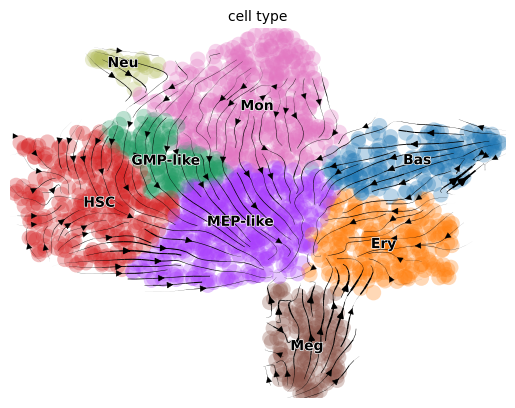

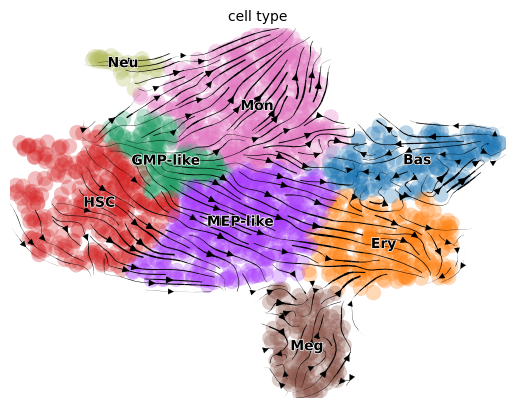

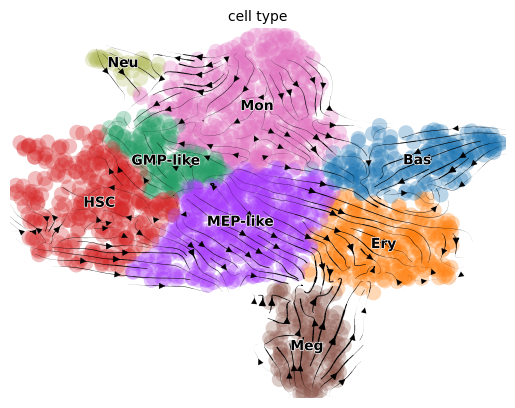

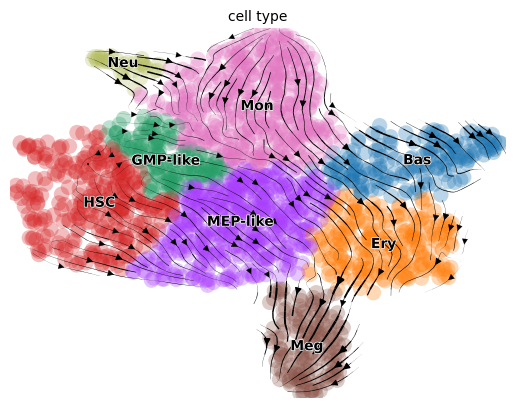

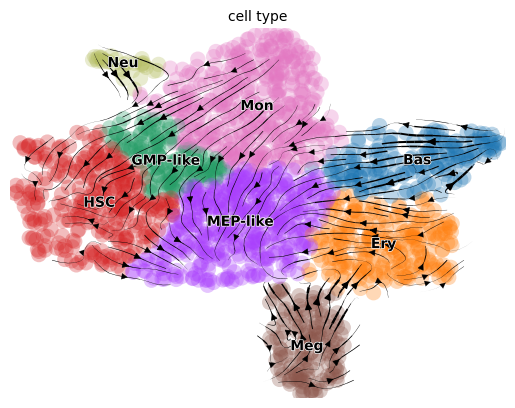

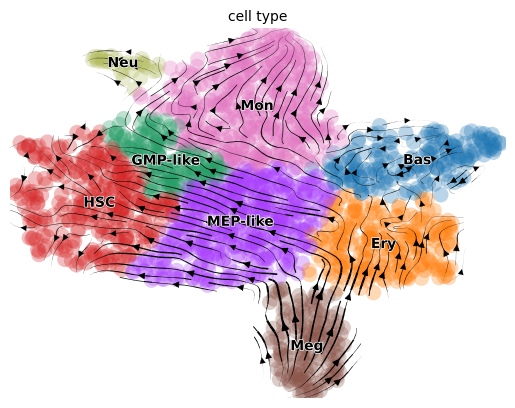

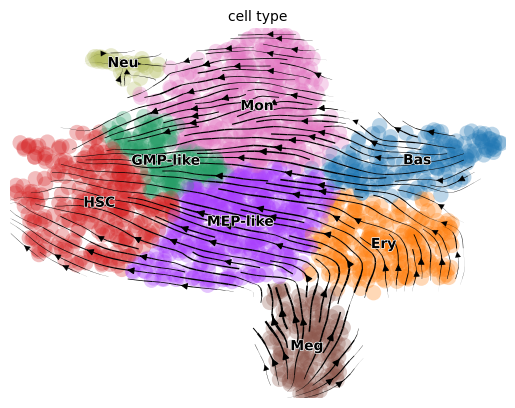

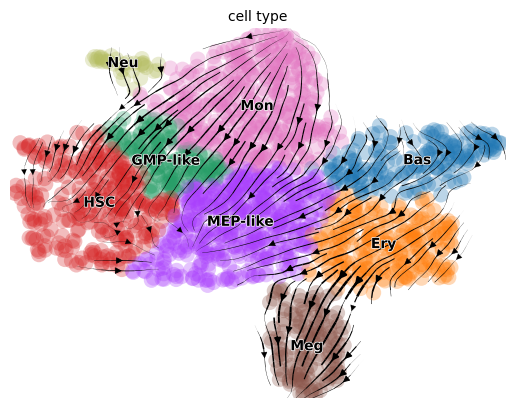

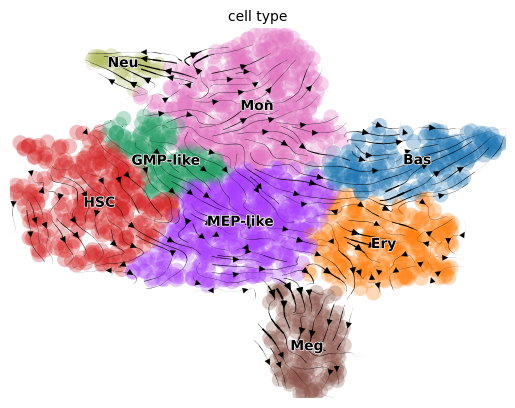

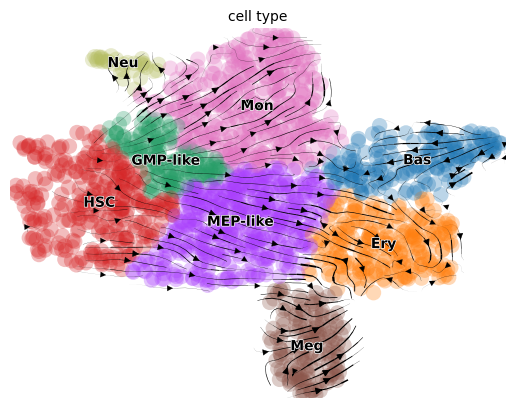

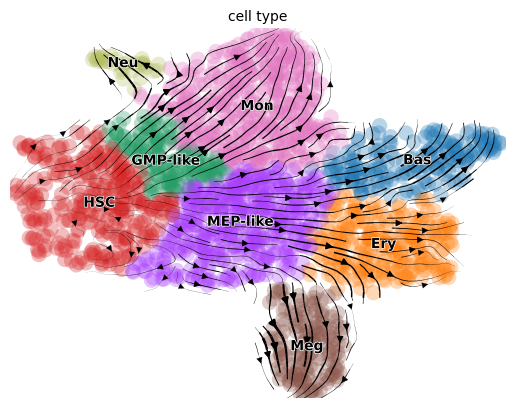

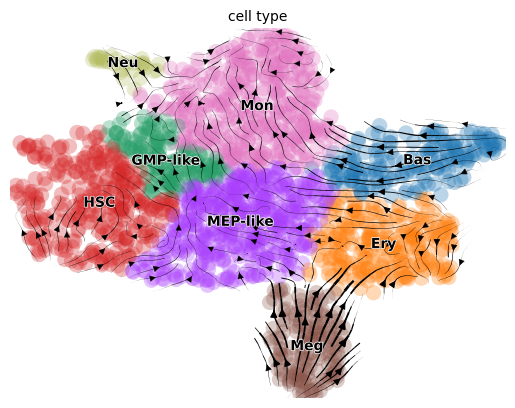

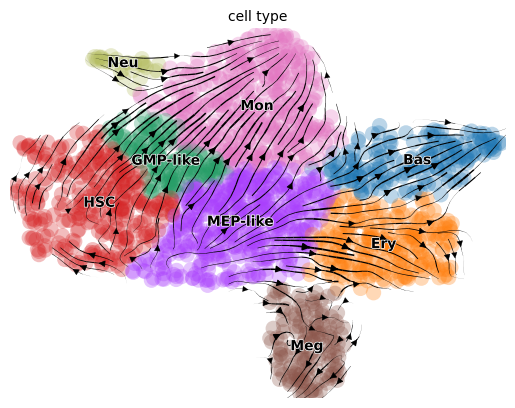

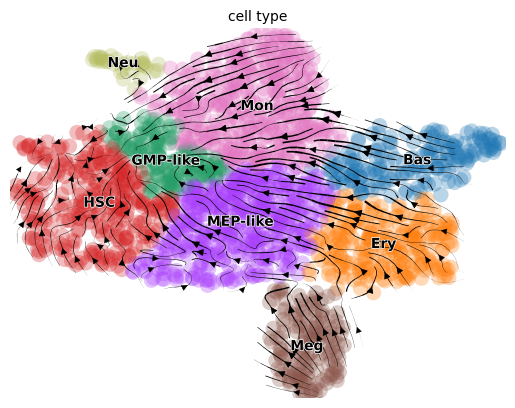

In [3]:
path = 'adata_graph/'
cell_cosine_sim_list = []
method_name_list = []

for method in methods:
    adata = sc.read_h5ad(path + method + '.h5ad')
    
    if method == 'TFvelo':
        n_cells = adata.shape[0]
        expanded_scaling_y = np.expand_dims(np.array(adata.var['fit_scaling_y']),0).repeat(n_cells,axis=0)
        adata.layers['velocity'] = adata.layers['velo_hat'] / expanded_scaling_y
        scv.tl.velocity_graph(adata,vkey="velocity",n_jobs=26,basis= "umap")

    # update obsm velocity_umap
    scv.pl.velocity_embedding_stream(adata,basis= 'umap',vkey='velocity',show=False,recompute=True,color="cell_type") 
    
    cosine_sim_cell_matrix = cosine_similarity(adata.obsm['scNT_velocity_umap'], adata.obsm['velocity_umap'])
    cosine_sim_cell = np.diag(cosine_sim_cell_matrix)
    cell_cosine_sim_list.append(cosine_sim_cell)

    if method in method_replacements.keys():
        title_name = method_replacements[method]
    else:
        title_name = method
    
    method_name_list.append(title_name)

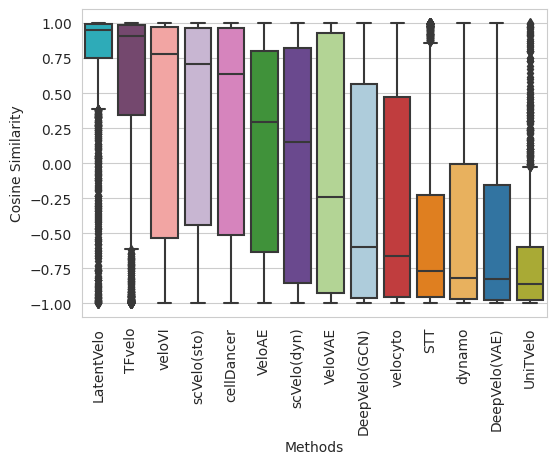

In [4]:

df = pd.DataFrame(cell_cosine_sim_list).T
df.columns = method_name_list # methods name from file

index_sort = df.median().sort_values(ascending=False).index
df= df[index_sort]

plt.figure(figsize=(6,4))
sns.set_style("whitegrid")

sns.boxplot(data=df, palette=method_palette)

plt.xlabel('Methods')
plt.ylabel('Cosine Similarity')

ax = plt.gca()
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

plt.savefig('Cosine_sim.pdf',bbox_inches='tight')
plt.show()

df.to_csv('scNT.csv')